# Simplicial-to-Combinatorial Coface Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***

### Imports and utilities

In [1]:
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import SimplicialLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "KarateClub"
dataset_config = load_dataset_config(dataset_name)
loader = SimplicialLoader(dataset_config)


Dataset configuration for KarateClub:

{'data_name': 'KarateClub',
 'data_domain': 'simplex',
 'data_dir': 'datasets/simplex/simplex',
 'data_type': 'simplex',
 'num_features': 2,
 'num_classes': 2}


We can then access to the data through the `load()`method, additionally a `CustomDataset` is wrapped around the dataset since `SimplicialLoader` returns `Data` not `Dataset` object

/Users/martincarrasco/miniconda3/envs/topox/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)



Dataset only contains 1 sample:


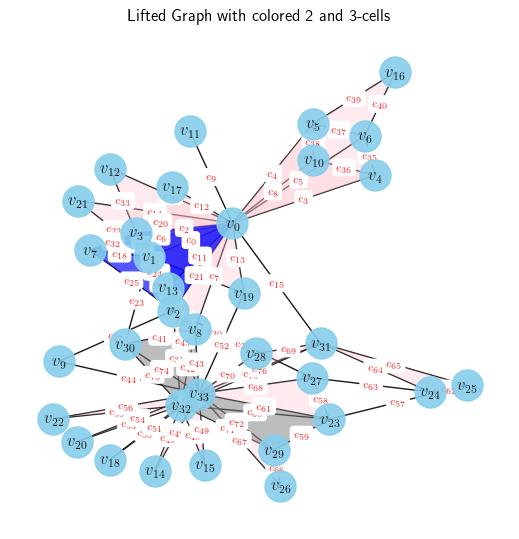

 - The complex has 34 0-cells.
 - The 0-cells have features dimension 2
 - The complex has 78 1-cells.
 - The 1-cells have features dimension 2
 - The complex has 45 2-cells.
 - The 2-cells have features dimension 2
 - The complex has 11 3-cells.
 - The 3-cells have features dimension 2



In [3]:
dataset = loader.load()
from modules.data.utils.custom_dataset import CustomDataset
cdataset = CustomDataset([dataset], data_dir=loader.data_dir)
describe_data(cdataset)

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. This example uses the *coface lifting* technique to lift a simplicial complex of dimension 2 to a combinatorial complex of dimension 3 where the 3-cells are composed of the cofaces of the 2-cells.

***
[[1]](https://arxiv.org/pdf/2206.00606) Hajij, Mustafa, et al. "Topological deep learning: Going beyond graph data." arXiv preprint arXiv:2206.00606 (2022).
***

For combinatorial complexes creating a lifting involves creating a `CombinatorialComplex` object from topomodelx, extracting the simplices from the simplicial data given as a `Data` object and recreating the same cells in a `CombinatorialComplex` using the method `add_cell`. Then, the cofaces of the 2-cells are calculated and added as 3-cells to the same `CombinatorialComplex` using toponetx class. There is an option to keep the features in the config related to keeping or not of the features called `keep_features` and an additional event where the coface is an already existing 2-cell.

Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> simplicial complex -> hypergraph. 

In [14]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "simplicial2combinatorial/coface_cc_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for simplicial2combinatorial/coface_cc_lifting:

{'transform_type': 'lifting',
 'transform_name': 'CofaceCCLifting',
 'feature_lifting': 'ProjectionSum',
 'keep_features': False}


We than apply the transform via our `PreProcesor`:

In [25]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir, force_reload=True)
#describe_data(lifted_dataset)

Transform parameters are the same, using existing data_dir: /Users/martincarrasco/Documents/VU/research/tdl/challenge-icml-2024/datasets/simplex/simplex/KarateClub/lifting/2684507298

Dataset only contains 1 sample:


Processing...
Done!


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25,) + inhomogeneous part.

## Create and Run a Combinatorial NN Model

In [20]:
from modules.models.combinatorial.hmc import HMCModel

model_type = "combinatorial"
model_id = "hmc"
model_config = load_model_config(model_type, model_id)

model = HMCModel(model_config, dataset_config)


Model configuration for combinatorial HMC:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'negative_slope': 0.2}


In [22]:

y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 